# Machine Problem 3: NumPy CNN

### Import Libraries

In [12]:
import numpy as np
import os
import time
from scipy import signal
from imageio import imread
from random import shuffle
from matplotlib import pyplot as plt
import pickle
%matplotlib inline

### Preprocessing Functions

In [2]:
# load_images
    # Read in images and makes a list for each set in the form: [images, labels]
    # images: np array with dims [N x img_height x img width x num_channels]
    # labels: np array with dims [N x 1]. elephant = 0, lionfish = 1
    #
    # Returns:  train_set: The list [train_images, train_labels]
    #           val_set: The list [val_images, val_labels] 

def load_images():
    
    sets = ['train', 'val']
    
    data_sets = []
    for dset in sets:
        img_path = './bin_dataset/' + dset + '/ele'
        ele_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        img_path = './bin_dataset/' + dset + '/lio'
        lio_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        set_images = np.stack(ele_list + lio_list)
        N = set_images.shape[0]
        labels = np.ones((N,1))
        labels[0:int(N/2)] = 0
        data_sets.append([set_images, labels])

    train_set, val_set = data_sets

    print("Loaded", len(train_set[0]), "training images")
    print("Loaded", len(val_set[0]), "validation images")
    
    return train_set, val_set


# batchify
    # Inputs:    train_set: List containing images and labels
    #            batch size: The desired size of each batch
    #
    # Returns:   image_batches: A list of shuffled training image batches, each with size batch_size
    #            label_batches: A list of shuffled training label batches, each with size batch_size 

def batchify(train_set, batch_size):
    num_batches = int(len(train_set[0])/batch_size)
    image_batches = np.empty((num_batches,batch_size,100,100,3))
    label_batches = np.empty((num_batches,batch_size))
    seeds = np.arange(len(train_set[0]))
    np.random.shuffle(seeds)
    for i in range(num_batches):
        for j in range(batch_size):
            idx = seeds[i*batch_size + j]
            image_batches[i][j] = train_set[0][idx]
            label_batches[i][j] = train_set[1][idx]
    return image_batches,label_batches

### Network Functions

#### Activation Functions

In [3]:
# relu
    # Inputs:   x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:  out: Multi-dimensional array with same size of x 

def relu(x):
    
    # YOUR CODE HERE
    N,W,H,D = len(x),len(x[0]),len(x[0][0]),len(x[0][0][0])
    out = np.zeros((N,W,H,D))
    for i in range(N):
        for j in range(W):
            for k in range(H):
                for l in range(D):
                    out[i][j][k][l] = max(0,x[i][j][k][l])
    return out

def relu2(x):
    
    # YOUR CODE HERE
    N,F = len(x),len(x[0])
    out = np.zeros((N,F))
    for i in range(N):
        for j in range(F):
            out[i][j] = max(0,x[i][j])
    return out

# sigmoid
    # Inputs:    x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def sigmoid(x):
    
    # YOUR CODE HERE
    N = len(x)
    out = np.zeros(N)
    for i in range(N):
        out[i] = sig_help(x[i])
    return out

def sig_help(x):
    return 1/(1+ np.exp(-x))

# unit_step
    # Inputs:    x: Multi-dimensional array with size N along the first axis 
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def unit_step(x):
    
    # YOUR CODE HERE
#     N,W = len(x),len(x[0])
#     out = np.zeros((N,W))
#     for i in range(N):
#         for j in range(W):
#             if(x[i][j] > 0):
#                 out[i][j] = 1
    
    out = np.heaviside(x, 0)

    return out 

#### Layer Functions

In [14]:
# convolve2D
    # Inputs:    X: [N x height x width x num_channels]
    #            filters: [num_filters x filter_height x filter_width x num_input_channels]
    # 
    # Returns:   Xc: output array by convoling X and filters. [N x output_height x output_width x num_filters]

def convolve2D(X0, filters):
   
    N, X0_len, _, num_ch = X0.shape
    num_out_ch, filter_len, _, _ = filters.shape
    F0_side = X0_len - filter_len + 1

    F0 = []
    for n in range(N):
        for o_ch in range(num_out_ch):
            conv = 0
            for ch in range(num_ch):
                # YOUR CODE HERE
                f = filters[o_ch,:,:,ch]
                sample = X0[n]
                # print('sample size: ',sample)
                c = signal.convolve2d(sample[:,:,ch],f, mode='valid')
                conv += c
            if o_ch == 0:
                conv_stack = conv
            else:
                conv_stack = np.dstack((conv_stack, conv))
        conv_stack = conv_stack.tolist()
        F0.append(conv_stack)
    return F0


# maxPool
    # Inputs:    R0: [N x height x width x num_channels]
    #            mp_len: size of max pool window, also the stride for this MP
    # 
    # Returns:   p_out: output of pooling R0. [N x output_height x output_width x num_channels]
    #            R0_mask: A binary mask with the same size as R0. Indicates which index was chosen to be the max
    #            for each max pool window. This will be used for backpropagation.

def maxPool(R0, mp_len):

    N, R0_len, _, num_ch = R0.shape
    p_out_len = int((R0_len-mp_len)/mp_len + 1)

    R0_mask = np.zeros(R0.shape)
    p_out = np.zeros((N, p_out_len, p_out_len, num_ch))
    
    for n in range(N):
        for ch in range(num_ch):
            for row in range(p_out_len): 
                for col in range(p_out_len):
                    # YOUR CODE HERE
                    cells = []
                    for i in range(mp_len):
                        for j in range(mp_len):
                            if((row * mp_len + i) < R0_len  and (col * mp_len + j) < R0_len ):
                                cells.append(R0[n][row * mp_len + i][col * mp_len + j][ch])
                            else:
                                cells.append(0)
                    p_out[n][row][col][ch] = np.max(cells)
                    pool_index = np.argmax(cells)
#                     print(len(cells))
#                     for i in range(mp_len):
#                         for j in range(mp_len):
#                             if((row * mp_len + i) < R0_len  and (col * mp_len + j) < R0_len ):
#                                 R0_mask[n][row * mp_len + i][col * mp_len + j][ch] = pool_index                    
                    
                    
#                     window = R0[n,row*mp_len:(row+1)*mp_len-1,col*mp_len:(col+1)*mp_len-1,ch]
#                     window = np.array(window)
#                     max_val = window.max()
#                     p_out[n][row][col][ch] = max_val
                    i,j = np.unravel_index(pool_index, (mp_len,mp_len))
                    R0_mask[n][i+row*mp_len][j+col*mp_len][ch] = 1
#                     if (n == 2) and (ch == 2) and (row == 2) and (col == 2):
#                         print(window)
#                         print(R0_mask[n,row*mp_len:(row+1)*mp_len-1,col*mp_len:(col+1)*mp_len-1,ch])

    return p_out, R0_mask

# fc
    # Inputs:    X: [N x num_input_features]
    #            W: [num_input_features x num_fc_nodes]
    # 
    # Returns:   out: Linear combination of X and W. [N x num_fc_nodes]

def fc(X, W):
    
    # YOUR CODE HERE
    out = np.dot(X,W)
    return out

#### CNN Functions

In [5]:
# cnn_fwd
    # Inputs:    X0: batch of images. [N x img_height x img_width x num_channels]
    #            W0, W1, W2: Parameters of the CNN
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   sig: vector containing the output for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations that will be
    #            used in backpropagation
    
def cnn_fwd(X0, W0, W1, W2, mp_len):
    
    # F0 
    # YOUR CODE HERE
    F0 = convolve2D(X0, W0)
    R0 = relu(F0)
    # X1p 
    # YOUR CODE HERE
    X1p, R0_mask = maxPool(R0, mp_len)
    # X1 (flatten)
    # YOUR CODE HERE
    X1 = X1p.reshape(len(X0),-1)
    # FC Layers
    # YOUR CODE HERE
    F1 = fc(X1,W1)
    X2 = relu2(F1)
    F2 = fc(X2,W2)
    # Output
    # YOUR CODE HERE
    sig = sigmoid(F2)
    # Save outputs of functions for backward pass
    cache = {
        "F0":F0,
        "R0":R0,
        "X1p":X1p,
        "R0m":R0_mask,
        "X1":X1,
        "F1":F1,
        "X2":X2,
        "F2":F2      
    }
#     print("F0",F0.shape)
#     print("R0",R0.shape)
#     print("X1p",X1p.shape)
#     print("R0m",R0_mask.shape)
#     print("X1",X1.shape)
#     print("F1",F1.shape)
#     print("X2",X2.shape)
#     print("F2",F2.shape)
    
    return sig, cache


# loss
    # Inputs:    sig: vector containing the CNN output for each sample. [N x 1]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    # 
    # Returns:   L: Loss/error criterion for the model. 

def loss(sig, Y):
    
    # YOUR CODE HERE
    N = len(sig)
    L = 0
    for i in range(N):
        L += -Y[i]*np.log(sig[i]) - (1- Y[i])*np.log(1-sig[i])
    L = L/N
    return L


### Backprop Functions

In [6]:
# convolve2DBwd
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            dL_dF0: Gradient at the output of the conv layer. 
    # 
    # Returns:   dL_dW0. gradient of loss L wrt W0. Same size as W0

def convolve2DBwd(X0, dL_dF0):
    
    N, X0_len, _, num_ch = X0.shape
    _, dL_dF0_len, _, num_out_ch  = dL_dF0.shape
    filter_len = X0_len - dL_dF0_len + 1
    
    dL_dW0 = np.zeros((num_out_ch, filter_len, filter_len, num_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                # YOUR CODE HERE 
                A = X0[n,:,:,ch]
                B = dL_dF0[n,:,:,o_ch]

                #reverse A
                A_ = np.fliplr( np.flip(A,axis=0)) 
                B_ = np.fliplr(np.flip(B,axis=0))

#                 if (n == 0) and (o_ch == 0) and (ch == 0):
#                     print(A)
#                     print(A_)
                corr = signal.convolve2d(A, B_, mode='valid')    
#                 print("corr",corr)
                dL_dW0[o_ch,:,:,ch] += corr
    
    return dL_dW0


# maxPoolBwd
    # Inputs:    dL_dX1p: Gradient at the output of the MaxPool layer
    #            R0_mask: A binary mask with the same size as R0. Defined in maxPool
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   dL_dR0: Gradient at the output of ReLu
    
def maxPoolBwd(dL_dX1p, R0_mask,  mp_len):
    
    N, H, W, C = R0_mask.shape
    N, dH, dW, C = dL_dX1p.shape
    
    dL_dR0 = np.zeros(R0_mask.shape)
    
    for n in range(N):
        for ch in range(C):
            for row in range(dH):
                for col in range(dW):
                    # YOUR CODE HERE
                    window = R0_mask[n,row*mp_len:(row+1)*mp_len,col*mp_len:(col+1)*mp_len,ch]
                    i,j = np.unravel_index(window.argmax(), window.shape)                    
                    dL_dR0[n][i+row*mp_len][j+col*mp_len][ch] = dL_dX1p[n][row][col][ch]
#                     if (n == 0) and (ch == 0) and (row == 0) and (col == 0):
#                         print(window)
#                         print(dL_dR0[n,row*mp_len:(row+1)*mp_len-1,col*mp_len:(col+1)*mp_len-1,ch])
#                         print(i,j)
                    
    return dL_dR0

def dL_dF2(Y, cache):
    N = len(Y)
    F2 = cache['F2']
    dL_dF2 = np.zeros((N,1))
    for i in range(N):
        dL_dF2[i] = (-1*Y[i]*(1-sigmoid(F2[i])) + (1-Y[i])*sigmoid(F2[i]))
    dL_dF2 /= N
    return dL_dF2

# dL_dW2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW2: Gradient of the Loss wrt W2
    
def dL_dW2(Y, cache):
   
    # YOUR CODE HERE
#     N = len(Y)
#     f2 = cache["F2"]
#     x2 = cache["X2"]
#     sig = sigmoid(f2)
#     dL_dW2 = 0
#     for i in range(N):
#         dL_dW2 += np.outer(sig[i]-Y[i],x2[i])
#     dL_dW2 = dL_dW2/N
#     dL_dW2 = dL_dW2.T

    dLdF2 = dL_dF2(Y, cache)
    X2 = cache['X2']
    dF2_dW2 = X2
    dL_dW2 = np.matmul(dF2_dW2.T, dLdF2)
    
    
    return dL_dW2    

# dL_dW1
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            W2: Weight matrix for the second FC layer
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW1: Gradient of the Loss wrt W1
    
def dL_dW1(Y, W2, cache):
    
    # YOUR CODE HERE
#     N = len(Y)
#     f2 = cache["F2"]
#     f1 = cache["F1"]
#     x1 = cache["X1"]
#     sig = sigmoid(f2)
#     unit = unit_step(f1) 
#     dL_dW1 = 0
#     for i in range(N):
#         dL_dW1 += np.outer( np.dot(sig[i]-Y[i], np.transpose(W2)) *unit[i]  ,x1[i])   
#     dL_dW1 = dL_dW1/N
#     dL_dW1 = dL_dW1.T

    F1 = cache['F1']
    X1 = cache['X1']
    dLdF2 = dL_dF2(Y, cache)
    dF2dX2 = W2
    dX2dF1 = unit_step(F1)
    dF1dW1 = X1
    A = np.matmul(dLdF2, dF2dX2.T)
    B = A * dX2dF1
    dL_dW1 = np.matmul(dF1dW1.T, B)
    return dL_dW1
    
#     return dL_dW1


# dL_dW0
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    #            W1: Weight matrix for the first FC layer
    #            W2: Weight matrix for the second FC layer
    #            mp_len: the length of one side of the max pool window
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW0: Gradient of the Loss wrt W0

def dL_dW0(X0, Y, W1, W2, mp_len, cache):
    
    N, X1p_len, _, no_out_ch  = cache['X1p'].shape
    F2 = cache['F2']
    F1 = cache['F1']
    R0m = cache['R0m']
    F0 = cache['F0']
    
    #dL_dF2
    # YOUR CODE HERE
    dLdF2 = dL_dF2(Y, cache) 
#     print("dldF2", dLdF2.shape)
#     print("dldF2", dLdF2)

    #dL_dF1
    # YOUR CODE HERE
    
    dF2_dX2 = W2
    dX2_dF1 = unit_step(F1)
    dL_dF1 = np.dot(dLdF2, dF2_dX2.T) * dX2_dF1  
#     print(np.matmul(dLdF2, dF2_dX2.T).shape)
#     print("dldf1",dL_dF1.shape)
#     print("dldf1",dL_dF1)

    #dL_dX1
    # YOUR CODE HERE

    dF1_dX1 = W1
    dL_dX1 = np.dot(dL_dF1, dF1_dX1.T)
#     print("dldx1", dL_dX1.shape)
#     print("dldx1", dL_dX1)

    # dL_dX1p (unflatten)
    # YOUR CODE HERE
    dL_dX1p = dL_dX1.reshape(cache['X1p'].shape) 
#     print("dldx1p", dL_dX1p.shape)
#     print("dldx1p", dL_dX1p)

    # dL_dR0 (unpool)
    # YOUR CODE HERE
    dL_dR0 = maxPoolBwd(dL_dX1p, R0m, mp_len)
#     print("dL_dR0", dL_dR0.shape)
#     print("dL_dR0", dL_dR0)

    # dL_dF0 (relu_bwd)
    # YOUR CODE HERE
    dR0_dF0 = unit_step(F0)
#     dR0_dF0 = unit_step(dL_dR0)
#     print(np.sum(dR0_dF0))
#     print("len",16*96*96*3)
    dL_dF0 = dL_dR0 *  dR0_dF0
#     print("dL_dF0",dL_dF0.shape)
#     print("dL_dF0",dL_dF0)

    # dL_dW0
    # YOUR CODE HERE
    dL_dW0 = convolve2DBwd(X0, dL_dF0)
#     print("dldw0", dL_dW0.shape)
#     print("dldw0", dL_dW0)
    
    return dL_dW0

In [7]:
a = np.arange(9).reshape(3,3)
a_ = np.fliplr( np.flip(a,axis=0)) 
print(a)
print(a_)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[8 7 6]
 [5 4 3]
 [2 1 0]]


### Training

#### Load Images

In [8]:
# Load images and scale them
# YOUR CODE HERE
ts, vs = load_images()
#normalize
train_set = []
train_set.append(ts[0].astype(float))
train_set.append(ts[1])

val_set = []
val_set.append(vs[0].astype(float))
val_set.append(vs[1])

for n in range(len(train_set[0])):
    for i in range(len(train_set[0][0])):
        for j in range(len(train_set[0][0][0])):
            for ch in range(len(train_set[0][0][0][0])):
                train_set[0][n][i][j][ch] = train_set[0][n][i][j][ch] /255

for n in range(len(val_set[0])):
    for i in range(len(val_set[0][0])):
        for j in range(len(val_set[0][0][0])):
            for ch in range(len(val_set[0][0][0][0])):
                val_set[0][n][i][j][ch] = val_set[0][n][i][j][ch] /255

Loaded 2000 training images
Loaded 800 validation images


#### Config

In [23]:
# Hyperparameters
epochs = 20
lr = 0.1
batch_size = 16
filter_len = 5
num_out_ch = 3
mp_len = 12
fc_nodes = 2

In [25]:
# Declare weights
myw0 = 0.05*np.random.randn(3,5,5,3)
myw1 = 0.05*np.random.randn(192,2)
myw2 = 0.05*np.random.randn(2,1)
weights_saver = []
train_acc_saver = []
for epochnum in range(epochs):
    # make set of batches
    img_batches,label_batches = batchify(train_set,batch_size)
    num_batches = len(img_batches)
    for b_idx in range(num_batches):
        X = np.array(img_batches[b_idx])
        Y = np.array(label_batches[b_idx])
        
        # Forward pass
        mysig,mycache = cnn_fwd(X, myw0, myw1, myw2, mp_len)
        
        # Calculate gradients
        w0grad = dL_dW0(X, Y, myw1, myw2, mp_len, mycache)        
        w1grad = dL_dW1(Y, myw2, mycache)
        w2grad = dL_dW2(Y, mycache)
        
        # Update gradients
        myw2 = myw2 - lr* w2grad
        myw1 = myw1 - lr* w1grad
        myw0 = myw0 - lr* w0grad
    weights_saver.append((myw0,myw1,myw2))
    sig, _ = cnn_fwd(val_set[0], myw0, myw1, myw2, mp_len)
    train_acc = 0
    for sigi in range(len(sig)):
        if(np.round(sig[sigi])==val_set[1][sigi]):
            train_acc +=1
    train_acc = (train_acc/len(sig))
    train_acc_saver.append(train_acc)
    print("Training accuracy for epoch ",epochnum+1,":",train_acc)

Epoch 1
Training accuracy for epoch  0 : 0.5025
Epoch 2
Training accuracy for epoch  1 : 0.73125
Epoch 3
Training accuracy for epoch  2 : 0.8025
Epoch 4
Training accuracy for epoch  3 : 0.7175
Epoch 5
Training accuracy for epoch  4 : 0.785
Epoch 6
Training accuracy for epoch  5 : 0.79625
Epoch 7
Training accuracy for epoch  6 : 0.685
Epoch 8
Training accuracy for epoch  7 : 0.82875
Epoch 9
Training accuracy for epoch  8 : 0.8325
Epoch 10
Training accuracy for epoch  9 : 0.83
Epoch 11
Training accuracy for epoch  10 : 0.83375
Epoch 12
Training accuracy for epoch  11 : 0.81625
Epoch 13
Training accuracy for epoch  12 : 0.83375
Epoch 14
Training accuracy for epoch  13 : 0.835
Epoch 15
Training accuracy for epoch  14 : 0.7975
Epoch 16
Training accuracy for epoch  15 : 0.85625
Epoch 17
Training accuracy for epoch  16 : 0.68375
Epoch 18
Training accuracy for epoch  17 : 0.83125
Epoch 19
Training accuracy for epoch  18 : 0.845
Epoch 20
Training accuracy for epoch  19 : 0.8675


### Training Accuracy Plot

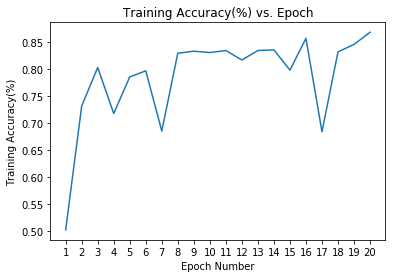

In [32]:
plt.plot(range(1,21),train_acc_saver)
plt.xticks(range(1,21))
plt.title("Training Accuracy(%) vs. Epoch")
plt.xlabel("Epoch Number")
plt.ylabel("Training Accuracy(%)")
plt.show()

### Convolution of Images

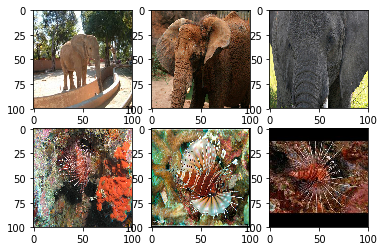

In [34]:
def convRGB(Im,Filter):
    conv_out = np.zeros(Im.shape)
    for channel in range(3):
        conv_im = Im[:,:,channel]
        filt = Filter[:,:,channel]
#         print(conv_im.shape)
#         print(filt.shape)
        out = signal.convolve2d(conv_im,filt*255,mode='same')
        Max = np.max(out)
        out = out/Max
#         print(out.shape)
        conv_out[:,:,channel] = out
    return conv_out
        


img1 = val_set[0][0]
img2 = val_set[0][1]
img3 = val_set[0][3]
img4 = val_set[0][417]
img5 = val_set[0][446]
img6 = val_set[0][498]

plt.subplot(231)
plt.imshow(np.asarray(img1))
plt.subplot(232)
plt.imshow(np.asarray(img2))
plt.subplot(233)
plt.imshow(np.asarray(img3))
plt.subplot(234)
plt.imshow(np.asarray(img4))
plt.subplot(235)
plt.imshow(np.asarray(img5))
plt.subplot(236)
plt.imshow(np.asarray(img6))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


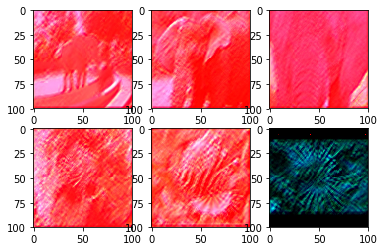

In [35]:
i = 0
conv1 =convRGB(img1,myw0[i])
conv2 =convRGB(img2,myw0[i])
conv3 =convRGB(img3,myw0[i])
conv4 =convRGB(img4,myw0[i])
conv5 =convRGB(img5,myw0[i])
conv6 =convRGB(img6,myw0[i])

plt.subplot(231)
plt.imshow(np.asarray(conv1))
plt.subplot(232)
plt.imshow(np.asarray(conv2))
plt.subplot(233)
plt.imshow(np.asarray(conv3))
plt.subplot(234)
plt.imshow(np.asarray(conv4))
plt.subplot(235)
plt.imshow(np.asarray(conv5))
plt.subplot(236)
plt.imshow(np.asarray(conv6))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


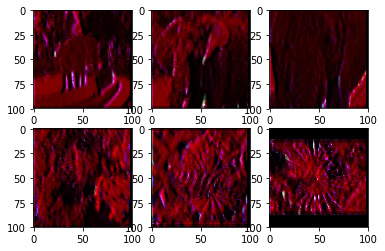

In [36]:
i = 1
conv1 =convRGB(img1,myw0[i])
conv2 =convRGB(img2,myw0[i])
conv3 =convRGB(img3,myw0[i])
conv4 =convRGB(img4,myw0[i])
conv5 =convRGB(img5,myw0[i])
conv6 =convRGB(img6,myw0[i])

plt.subplot(231)
plt.imshow(np.asarray(conv1))
plt.subplot(232)
plt.imshow(np.asarray(conv2))
plt.subplot(233)
plt.imshow(np.asarray(conv3))
plt.subplot(234)
plt.imshow(np.asarray(conv4))
plt.subplot(235)
plt.imshow(np.asarray(conv5))
plt.subplot(236)
plt.imshow(np.asarray(conv6))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


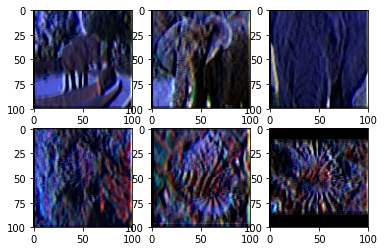

In [37]:
i = 2
conv1 =convRGB(img1,myw0[i])
conv2 =convRGB(img2,myw0[i])
conv3 =convRGB(img3,myw0[i])
conv4 =convRGB(img4,myw0[i])
conv5 =convRGB(img5,myw0[i])
conv6 =convRGB(img6,myw0[i])

plt.subplot(231)
plt.imshow(np.asarray(conv1))
plt.subplot(232)
plt.imshow(np.asarray(conv2))
plt.subplot(233)
plt.imshow(np.asarray(conv3))
plt.subplot(234)
plt.imshow(np.asarray(conv4))
plt.subplot(235)
plt.imshow(np.asarray(conv5))
plt.subplot(236)
plt.imshow(np.asarray(conv6))

[[0.92  0.08 ]
 [0.185 0.815]]
106
[14, 19, 21, 36, 51, 52, 116, 192, 201, 214, 215, 221, 225, 230, 237, 243, 263, 274, 285, 289, 305, 309, 312, 316, 317, 341, 360, 380, 382, 383, 389, 392, 400, 404, 409, 411, 417, 418, 419, 421, 432, 434, 435, 436, 444, 446, 448, 455, 457, 474, 477, 478, 491, 499, 500, 508, 509, 515, 518, 529, 534, 535, 545, 550, 551, 557, 564, 573, 576, 581, 586, 591, 594, 600, 601, 604, 608, 611, 612, 621, 629, 633, 635, 647, 657, 666, 668, 679, 686, 705, 725, 732, 735, 738, 745, 748, 749, 754, 758, 760, 762, 774, 775, 786, 789, 793]


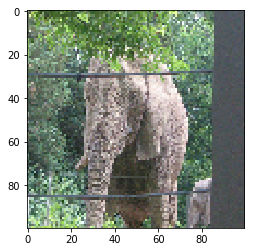

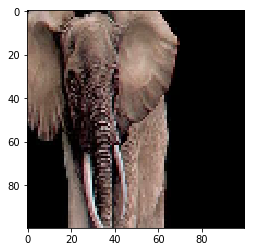

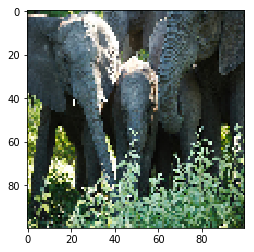

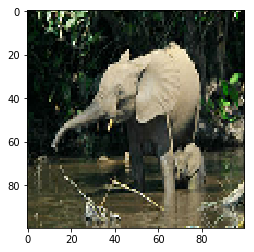

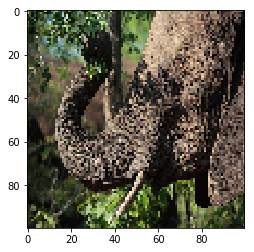

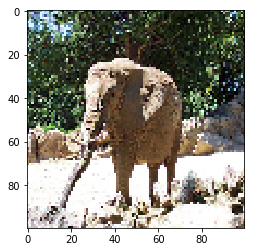

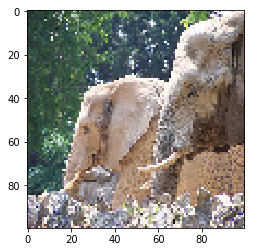

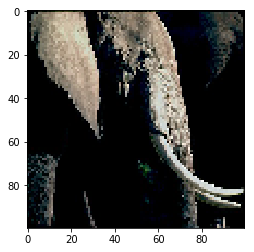

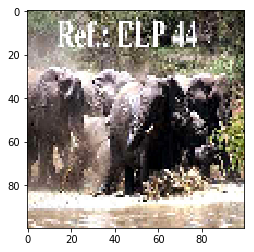

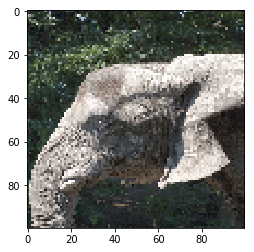

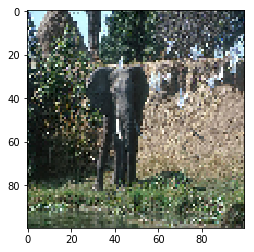

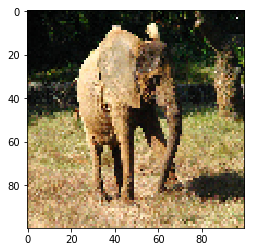

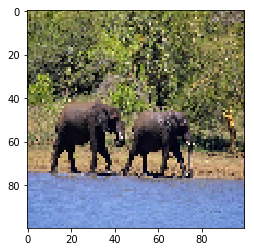

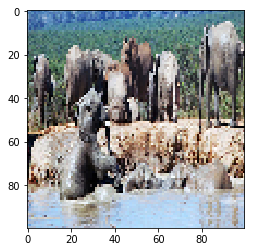

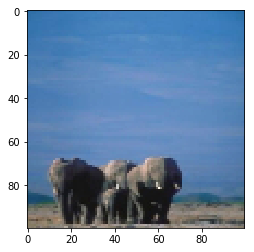

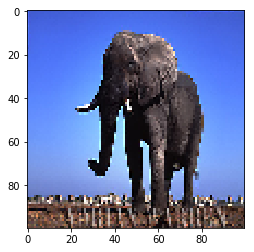

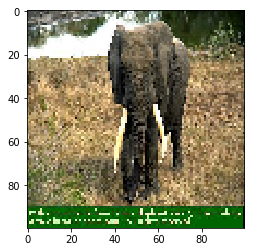

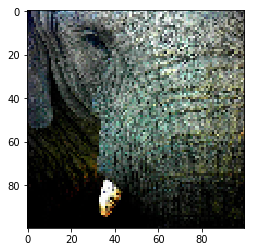

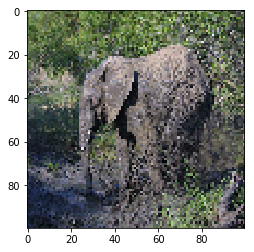

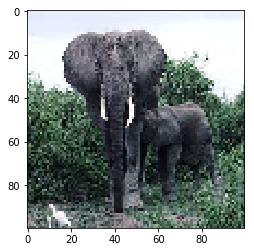

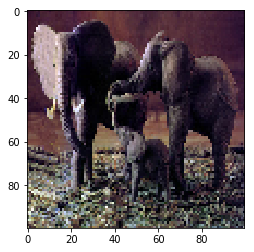

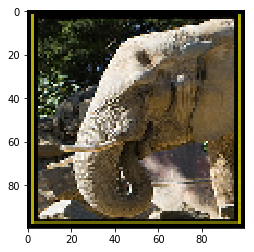

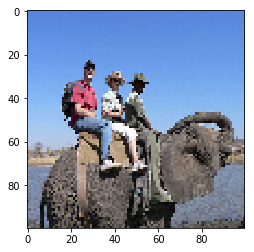

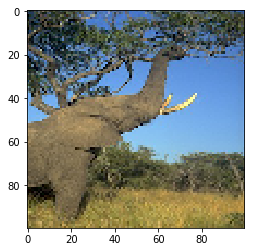

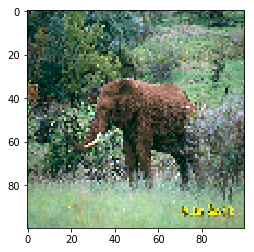

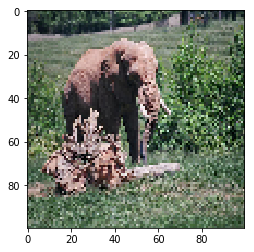

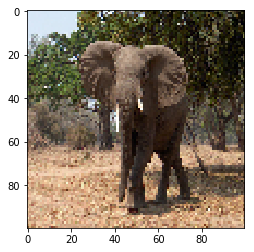

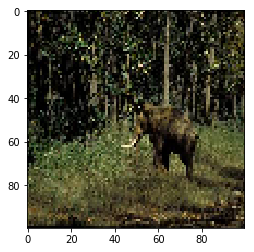

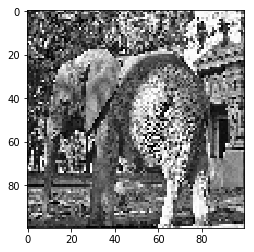

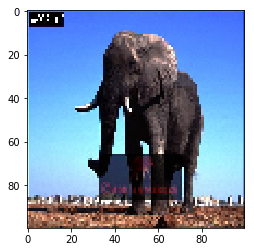

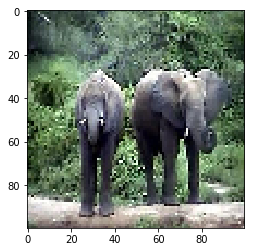

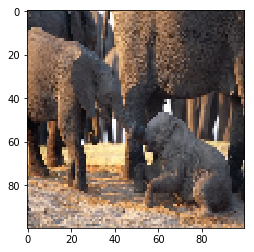

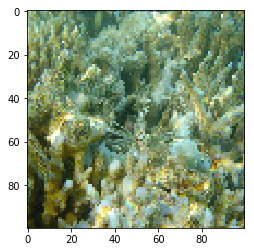

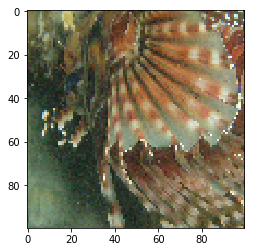

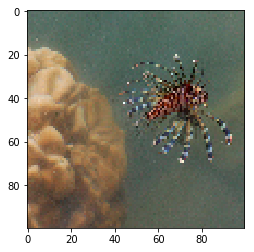

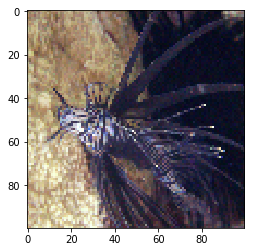

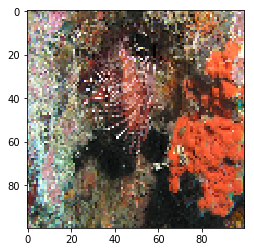

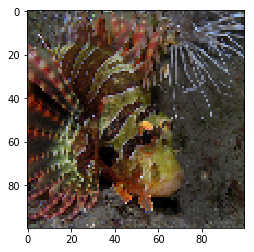

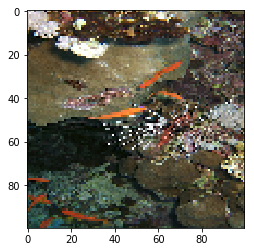

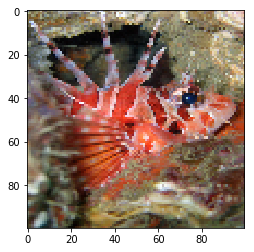

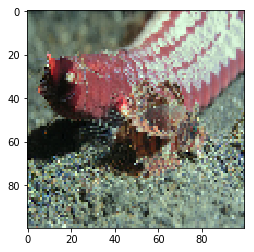

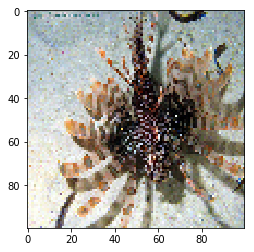

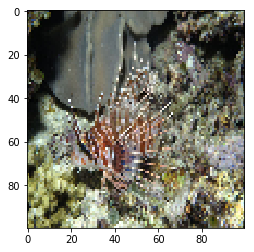

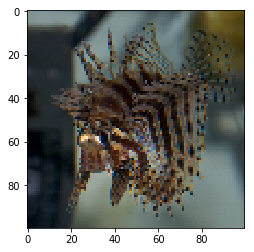

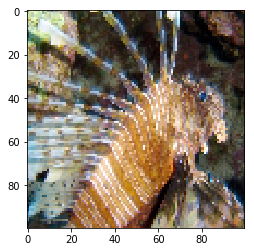

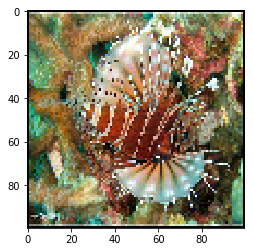

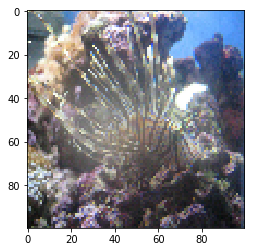

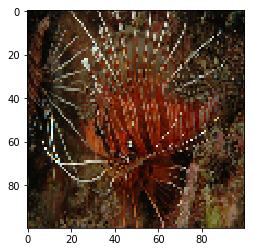

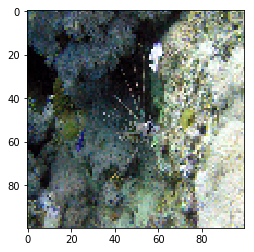

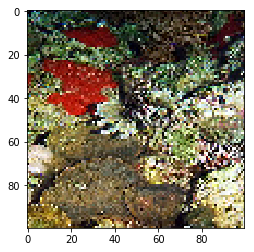

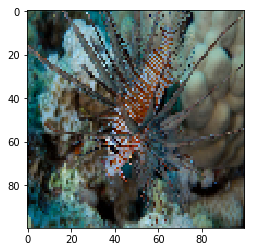

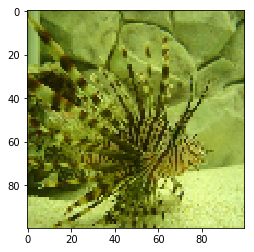

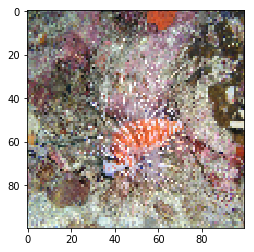

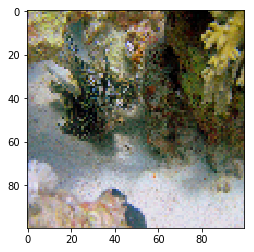

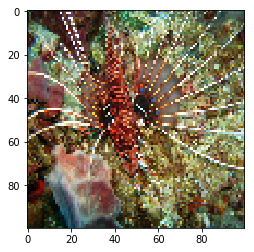

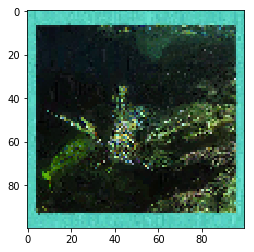

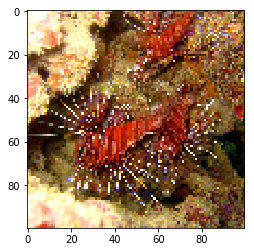

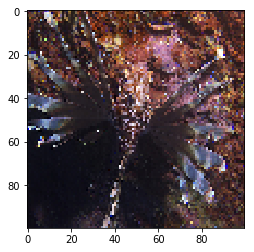

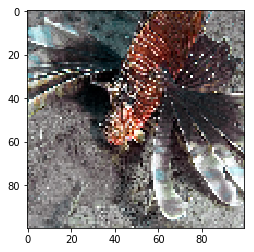

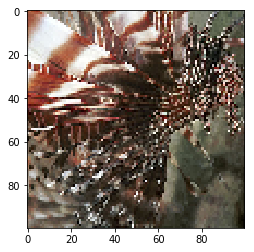

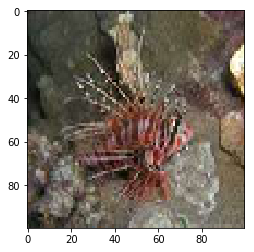

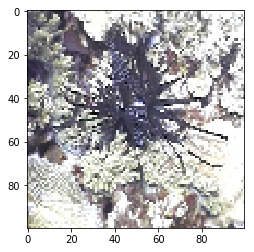

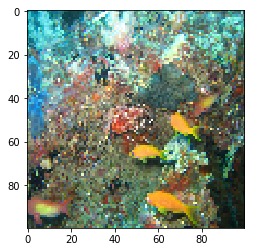

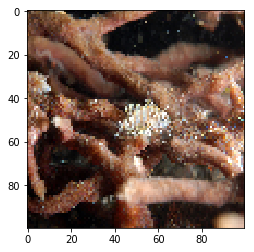

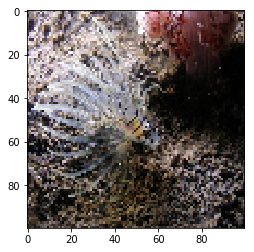

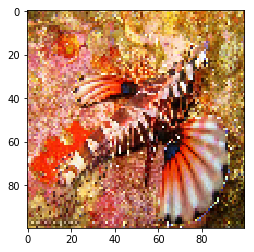

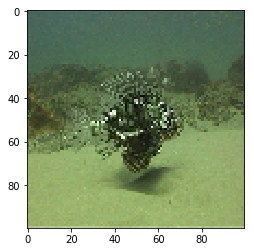

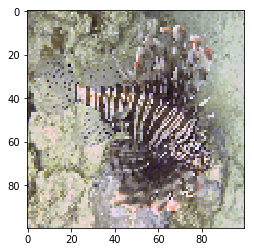

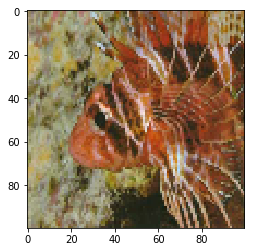

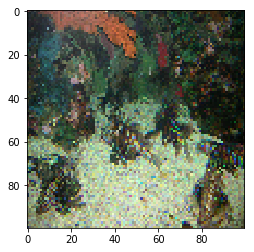

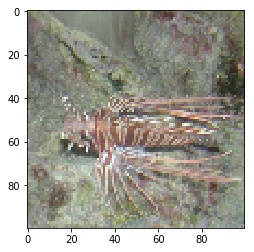

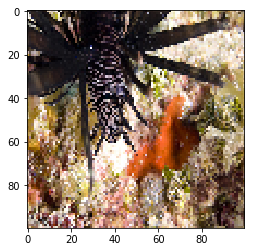

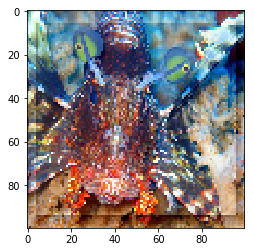

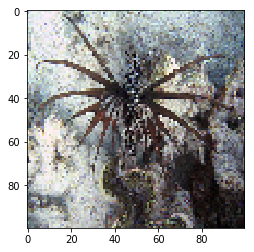

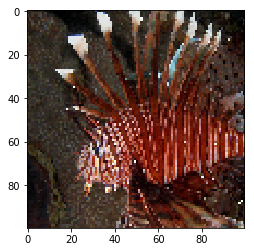

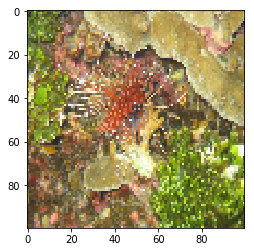

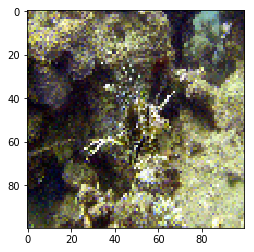

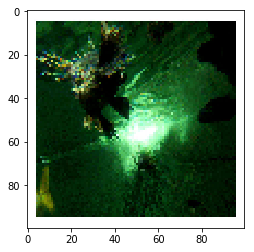

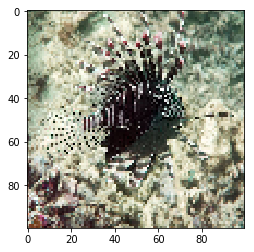

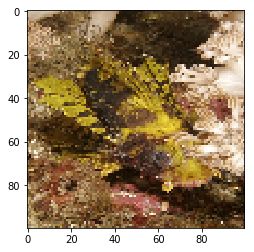

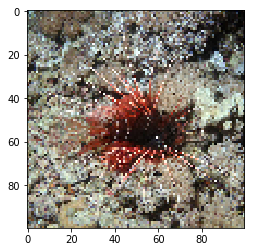

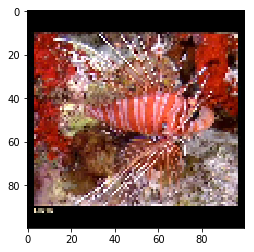

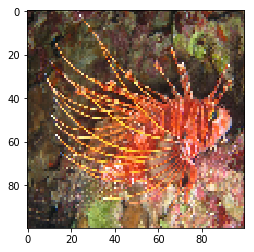

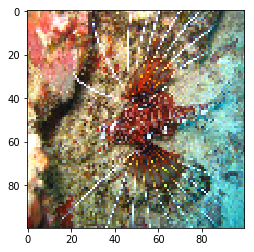

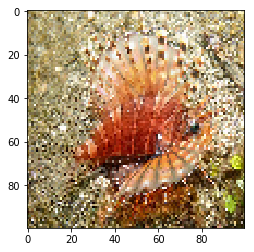

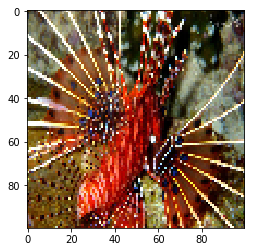

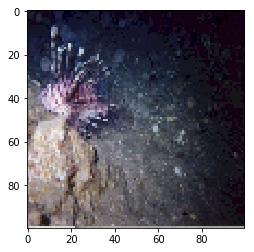

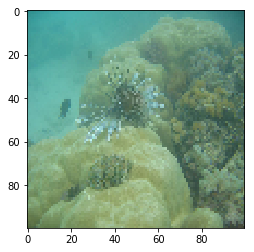

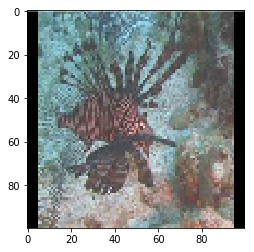

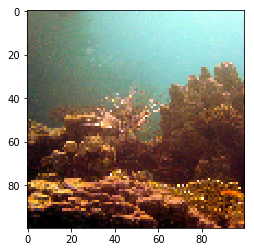

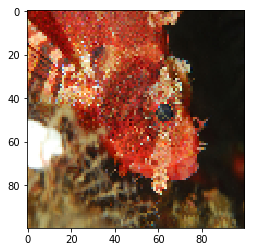

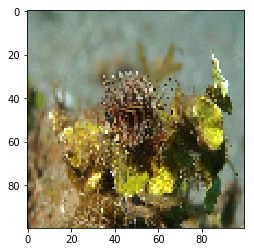

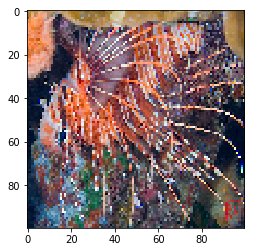

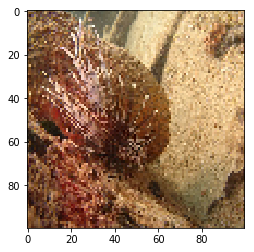

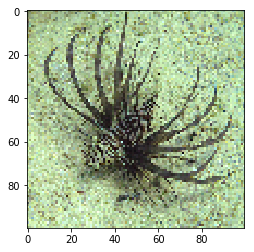

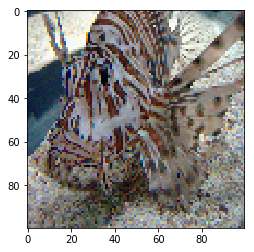

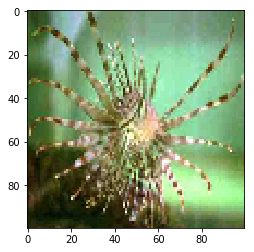

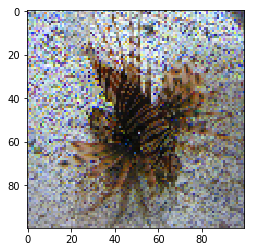

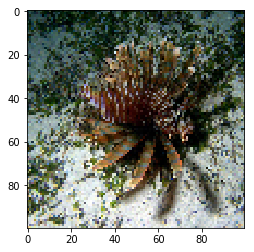

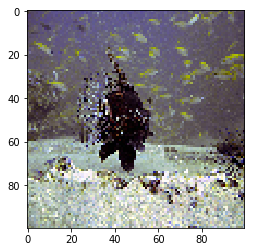

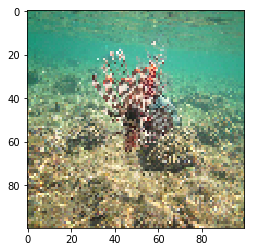

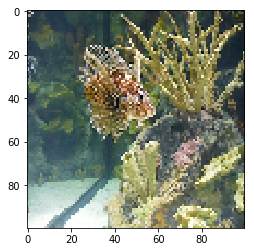

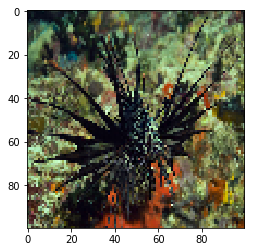

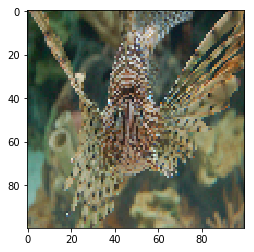

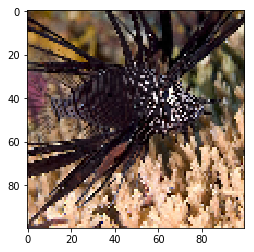

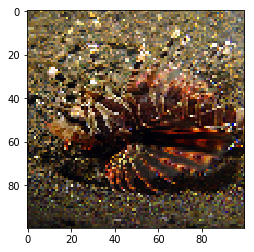

In [43]:
conf_mat = np.zeros((2,2))
incorrect = []
for i in range(len(val_set[1])):
    correct = int(val_set[1][i])
    guess = int(np.round(sig[i]))
    if(guess != correct):
        incorrect.append(i)
    conf_mat[correct][guess] += 1
conf_mat[0] = conf_mat[0] / (conf_mat[0][0]+conf_mat[0][1])
conf_mat[1] = conf_mat[1] / (conf_mat[1][0]+conf_mat[1][1])   
print(conf_mat)
print(len(incorrect))
print(incorrect)
incorrect_imags = []
for num in incorrect:
    incorrect_imags.append(val_set[0][num])
for im_num in range(len(incorrect_imags)):
    plt.imshow(np.asarray(incorrect_imags[im_num]))
    plt.pause(0.1)

### Test Correctness of Forward and Backward Pass

#### Forward

In [11]:
weights = np.load('weights.npz')
W0 = weights['W0']
W1 = weights['W1']
W2 = weights['W2']
print("W0 dim", W0.shape)
print("W1 dim", W1.shape)
print("W2 dim", W2.shape)
sig, _ = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
train_acc = 0
for i in range(len(sig)):
    if(np.round(sig[i])==val_set[1][i]):
        train_acc +=1
train_acc = (train_acc/len(sig))

print("train_loss:", loss(sig, val_set[1]), "train_acc:", train_acc)

W0 dim (3, 5, 5, 3)
W1 dim (192, 2)
W2 dim (2, 1)
F0 (800, 96, 96, 3)
R0 (800, 96, 96, 3)
X1p (800, 8, 8, 3)
R0m (800, 96, 96, 3)
X1 (800, 192)
F1 (800, 2)
X2 (800, 2)
F2 (800, 1)
train_loss: [ 0.23271396] train_acc: 0.9175


#### Backward

In [12]:
# Make backprop testing batch
X_bp = np.vstack([train_set[0][0:8,:,:,:], train_set[0][-9:-1,:,:,:]])
Y_bp = np.vstack([train_set[1][0:8], train_set[1][-9:-1]])

# Initialize weights to all ones
# YOUR CODE HERE
W0 = np.ones((3,5,5,3))
W1 = np.ones((192,2))
W2 = np.ones((2,1))
# Update weights once
# YOUR CODE HERE
sig, cache = cnn_fwd(X_bp,W0,W1,W2, mp_len)
W2_grad = (dL_dW2(Y_bp,cache))
W1_grad = dL_dW1(Y_bp,W2,cache)
W0_grad = dL_dW0(X_bp, Y_bp, W1, W2, mp_len, cache)

W2 = W2 - lr* W2_grad
W1 = W1 - lr* W1_grad
W0 = W0 - lr* W0_grad

# print(dL_dW0(X_bp, Y_bp, W1, W2, mp_len, cache))
print("W2 value:", np.sum(W2))
print("W1 value:", np.sum(W1))
print("W0 value:", np.sum(W0))

F0 (16, 96, 96, 3)
R0 (16, 96, 96, 3)
X1p (16, 8, 8, 3)
R0m (16, 96, 96, 3)
X1 (16, 192)
F1 (16, 2)
X2 (16, 2)
F2 (16, 1)
dldF2 (16, 1)
dldf1 (16, 2)
dldx1 (16, 192)
dldx1p (16, 8, 8, 3)
dL_dR0 (16, 96, 96, 3)
dL_dF0 (16, 96, 96, 3)
dldw0 (3, 5, 5, 3)
W2 value: -834.631617647
W1 value: -452.631617647
W0 value: -611.631617647
